# Predicting cell phenotypes using signaling signatures 
##                           Filtering insigificant phosphopeptides

In [5]:
import scipy as sp, numpy as np, pandas as pd, math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut
from numpy import random
from sklearn.cluster import KMeans
from Bio import SeqIO
from distance_calculation import Distance
from collections import defaultdict

## Importing Data

In [6]:
X = np.array(pd.read_csv('./MS_Initial_Data.csv', header=0))
Y = np.array(pd.read_csv('./Ydata.csv', header=0))
treatments_axl = np.array(pd.read_csv('./MS_Initial_Data.csv', header=None))[0,2:]
treatments_cv = np.delete(treatments_axl,[3,7,8,9])

peptide_phosphosite = X[:,0]
protein_description = X[:,1]
ProtNames = []
for item in protein_description:
    ProtName = item.split("OS")
    ProtName = ProtName[0]
    ProtNames.append(ProtName)
PC9 = X[:,2]
Erl = X[:,3]
R428 = X[:,4]
Erl_R428 = X[:,5]
Erl_HGF = X[:,6]
Erl_FGF = X[:,7]
Erl_IGF = X[:,8]
KO_Erl = X[:,9]
KO_R428 = X[:,10]
KO_Erl_R428 = X[:,11]

# for AXL expression
X_axl = np.concatenate([PC9,Erl,R428,Erl_R428,Erl_HGF,Erl_FGF,Erl_IGF,KO_Erl,KO_R428,KO_Erl_R428])
X_axl = np.reshape(X_axl,(10,300))
Y_axl = Y[:,3]
Y_axl = Y_axl[:10]
print(Y_axl)

# for cell viability
X_cv = np.concatenate([PC9,Erl,R428,Erl_R428,Erl_HGF,Erl_FGF,Erl_IGF,KO_Erl,KO_R428,KO_Erl_R428])
X_cv = np.reshape(X_cv,(10,300))
Y_cv = Y[:,2]
Y_cv = Y_cv[:10]

[527.0 389.0 383.0 404.0 410.0 409.0 406.0 90.6 55.6 49.9]


In [7]:
Y_axl_z = sp.stats.zscore(Y_axl)
Y_cv_z = sp.stats.zscore(Y_cv)

def zscore_columns(matrix):
    matrix_z = np.zeros((matrix.shape[0],matrix.shape[1]))
    for a in range(matrix.shape[1]):
        column = []
        column = matrix[:,a]
        column_mean = np.mean(column)
        column_std = np.std(column)
        matrix_z[:,a] = np.asmatrix([(column-column_mean)/column_std])
    return matrix_z

X_axl_z = np.array(zscore_columns(X_axl.copy()))
X_cv_z = np.array(zscore_columns(X_cv.copy()))

## Determining Number of Components (Raw Data)

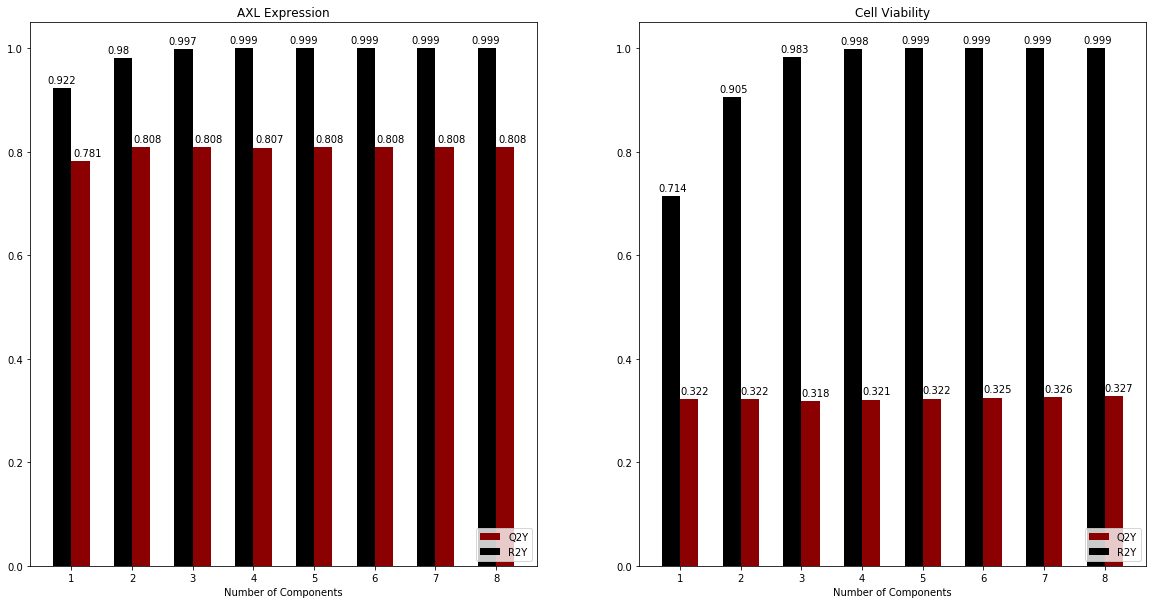

In [8]:
def R2Y_across_components(X_z,Y_z,max_comps,sublabel):
    R2Ys = []
    components = []
    for b in range(1,max_comps):
        plsr = PLSRegression(n_components = b)
        X_scores, Y_scores = plsr.fit_transform(X_z,Y_z)
        R2Y = plsr.score(X_z,Y_z)
        R2Ys.append(R2Y)
        components.append(b)
    return R2Ys

loo = LeaveOneOut()

def Q2Y_across_components(X_z,Y_z,max_comps,sublabel):
    PRESS = 0
    SS = 0
    Q2Ys = []
    for b in range(1,max_comps):
        plsr_model = PLSRegression(n_components = b)
        for train_index, test_index in loo.split(X_z, Y_z):
            X_train, X_test = X_z[train_index], X_z[test_index]
            Y_train, Y_test = Y_z[train_index], Y_z[test_index]
            X_train = zscore_columns(X_train)
            Y_train = sp.stats.zscore(Y_train)
            plsr_model.fit_transform(X_train,Y_train)
            Y_predict_cv = plsr_model.predict(X_test)
            PRESS_i = (Y_predict_cv - Y_test) ** 2
            SS_i = (Y_test) ** 2
            PRESS = PRESS + PRESS_i
            SS = SS + SS_i
        Q2Y = 1 - (PRESS/SS)
        Q2Ys.append(Q2Y)
    return Q2Ys
        
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,ax,spac1,spac2,dec):
    for l, m in enumerate(x):
        axs[ax].text(l+spac1,m+spac2,str(truncate(m,dec)))

Q2Y_axl = np.squeeze(Q2Y_across_components(X_axl_z,Y_axl_z,9,'AXL Expression'))
Q2Y_cv = np.squeeze(Q2Y_across_components(X_cv_z,Y_cv_z,9,'Cell Viability')) 
R2Y_axl = R2Y_across_components(X_axl_z,Y_axl_z,9,'AXL Expression')
R2Y_cv = R2Y_across_components(X_cv_z,Y_cv_z,9,'Cell Viability') 
range_axl = np.linspace(1,8,8)
range_cv = np.linspace(1,8,8)

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].bar(range_axl+0.15,Q2Y_axl,width=0.3,align='center',label='Q2Y', color = "darkred")
axs[0].bar(range_axl-0.15,R2Y_axl,width=0.3,align='center',label='R2Y', color = "black")
axs[0].legend(loc=4)
axs[0].set(xlabel='Number of Components',title='AXL Expression')
disp_values(Q2Y_axl,0,1.03,0.01,3)
disp_values(R2Y_axl,0,0.6,0.01,3)
axs[1].bar(range_cv+0.15,Q2Y_cv,width=0.3,align='center',label='Q2Y', color = "darkred")
axs[1].bar(range_cv-0.15,R2Y_cv,width=0.3,align='center',label='R2Y', color = "black")
axs[1].set(xlabel='Number of Components',title='Cell Viability')
disp_values(Q2Y_cv,1,1,0.01,3)
disp_values(R2Y_cv,1,0.65,0.01,3)
axs[1].legend(loc=4)
plt.show()

## Running PLSR for Each Phenotype (Raw Data)

In [9]:
plsr_axl = PLSRegression(n_components = 3)
X_scores_axl, Y_scores_axl = plsr_axl.fit_transform(X_axl_z,Y_axl_z)
PC1_scores_axl, PC2_scores_axl = X_scores_axl[:,0], X_scores_axl[:,1]
PC1_xload_axl, PC2_xload_axl = plsr_axl.x_loadings_[:,0], plsr_axl.x_loadings_[:,1]
PC1_yload_axl, PC2_yload_axl = plsr_axl.y_loadings_[:,0], plsr_axl.y_loadings_[:,1]

plsr_cv = PLSRegression(n_components = 3)
X_scores_cv, Y_scores_cv = plsr_cv.fit_transform(X_cv_z,Y_cv_z)
PC1_scores_cv, PC2_scores_cv = X_scores_cv[:,0], X_scores_cv[:,1]
PC1_xload_cv, PC2_xload_cv = plsr_cv.x_loadings_[:,0], plsr_cv.x_loadings_[:,1]
PC1_yload_cv, PC2_yload_cv = plsr_cv.y_loadings_[:,0], plsr_cv.y_loadings_[:,1]

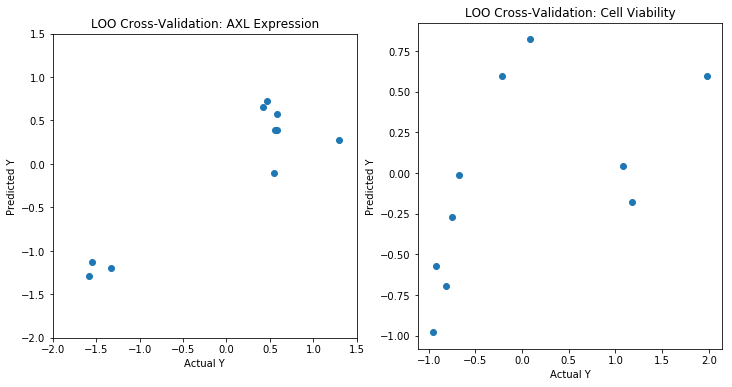

In [10]:
def cross_validation_plot(X,Y,plsr_model,ax,subtitle):
    Y_predictions = []
    for train_index, test_index in loo.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        X_train = zscore_columns(X_train)
        Y_train = sp.stats.zscore(Y_train)
        plsr_model.fit_transform(X_train,Y_train)
        Y_predict = plsr_model.predict(X_test)
        Y_predictions.append(Y_predict)
    Y_predictions = np.squeeze(Y_predictions)
    axs[ax].scatter(Y,np.squeeze(Y_predictions))
    axs[ax].set(title=subtitle,xlabel='Actual Y',ylabel='Predicted Y')

fig, axs = plt.subplots(1,2,figsize=(12,6))
cross_validation_plot(X_axl_z,Y_axl_z,plsr_axl,0,'LOO Cross-Validation: AXL Expression')
axs[0].set_xlim([-2, 1.5])
axs[0].set_ylim([-2, 1.5])
axs[0].set_aspect('equal')
cross_validation_plot(X_cv_z,Y_cv_z,plsr_cv,1,'LOO Cross-Validation: Cell Viability')
# axs[1].set_xlim([-1, -0.6])
# axs[1].set_ylim([-1, 0.1])
plt.show()

## Filtering insignificant phosphopeptides and K-means clustering

I'm currently filtering out any phosphopeptide whose phosphorylation levels don't change at least 2-fold (up or down) across any conditions 

In [11]:
def FilteringOutPeptides(X):            
    NewX = []
    for i, row in enumerate(np.transpose(X)):
        currentlist = []
        for value in row:
            if value >= 0.5 and value <= 2:
                continue
            else:
                currentlist.append(value)
        if len(currentlist) > 0:
            NewX.append(row)
    return np.squeeze(NewX)

X_F = FilteringOutPeptides(X_cv)

In [12]:
kmeans = KMeans(n_clusters=25)
kmeans.fit(X_F)
clusters_F = kmeans.fit_predict(X_F)

In [13]:
def ClusterAverages_F(X_, nClusters, nObs):
    ClusterAvgs = []
    DictClusterToAvgs = {}
    ClusterAvgs_arr = np.zeros((nClusters,nObs))
    for i in range(nClusters):
        CurrentCluster = []
        for idx, arr in enumerate(X_):
            if i == arr[0]:
                CurrentCluster.append(arr)
        CurrentCluster_T = np.transpose(CurrentCluster)
        CurrentAvgs = []
        for x, arr in enumerate(CurrentCluster_T):
            if x == 0:
                continue
            else:
                avg = np.mean(arr)
                CurrentAvgs.append(avg)
        DictClusterToAvgs[i] = CurrentAvgs
        ClusterAvgs_arr[i,:] = CurrentAvgs
        AvgsArr = np.transpose(ClusterAvgs_arr)
    return AvgsArr

X_FCl = np.insert(np.transpose(X_F), 0, clusters_F, axis = 0)
X_FCl = np.transpose(X_FCl)

Cluster_Avgs_F = ClusterAverages_F(X_FCl, 25, 10)
X_ClusterAvgs_Fz = zscore_columns(Cluster_Avgs_F)

##  Reimplementation of PLSR using Cluster Averages

In [14]:
plsr_cvF = PLSRegression(n_components = 3)
X_scores_cvF, Y_scores_cvF = plsr_cvF.fit_transform(X_ClusterAvgs_Fz,Y_cv_z)
PC1_scores_cvF, PC2_scores_cvF = X_scores_cvF[:,0], X_scores_cvF[:,1]
PC1_xload_cvF, PC2_xload_cvF = plsr_cvF.x_loadings_[:,0], plsr_cvF.x_loadings_[:,1]
PC1_yload_cvF, PC2_yload_cvF = plsr_cvF.y_loadings_[:,0], plsr_cvF.y_loadings_[:,1]

plsr_axlF = PLSRegression(n_components = 3)
X_scores_axlF, Y_scores_axlF = plsr_axlF.fit_transform(X_ClusterAvgs_Fz,Y_axl_z)
PC1_scores_axlF, PC2_scores_axlF = X_scores_axlF[:,0], X_scores_axlF[:,1]
PC1_xload_axlF, PC2_xload_axlF = plsr_axlF.x_loadings_[:,0], plsr_axlF.x_loadings_[:,1]
PC1_yload_axlF, PC2_yload_axlF = plsr_axlF.y_loadings_[:,0], plsr_axlF.y_loadings_[:,1]

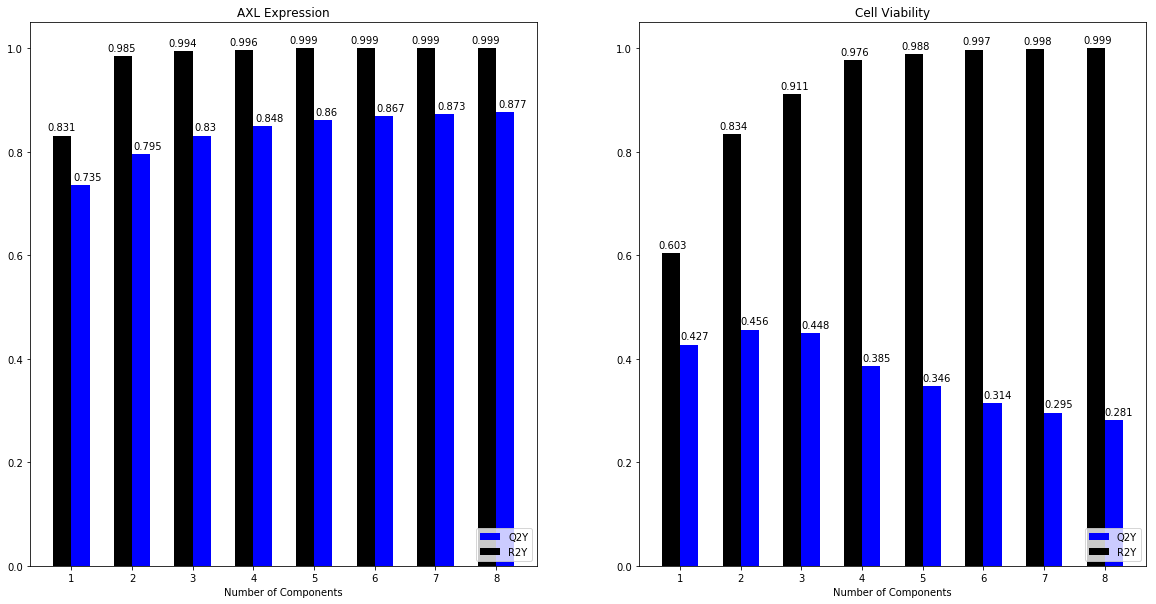

In [16]:
Q2Y_axlF = np.squeeze(Q2Y_across_components(X_ClusterAvgs_Fz,Y_axl_z,9,'AXL Expression'))
Q2Y_cvF = np.squeeze(Q2Y_across_components(X_ClusterAvgs_Fz,Y_cv_z,9,'Cell Viability')) 
R2Y_axlF = R2Y_across_components(X_ClusterAvgs_Fz,Y_axl_z,9,'AXL Expression')
R2Y_cvF = R2Y_across_components(X_ClusterAvgs_Fz,Y_cv_z,9,'Cell Viability') 

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].bar(range_axl+0.15,Q2Y_axlF,width=0.3,align='center',label='Q2Y', color = "blue")
axs[0].bar(range_axl-0.15,R2Y_axlF,width=0.3,align='center',label='R2Y', color = "black")
axs[0].legend(loc=4)
axs[0].set(xlabel='Number of Components',title='AXL Expression')
disp_values(Q2Y_axlF,0,1.03,0.01,3)
disp_values(R2Y_axlF,0,0.6,0.01,3)
axs[1].bar(range_cv+0.15,Q2Y_cvF,width=0.3,align='center',label='Q2Y', color = "blue")
axs[1].bar(range_cv-0.15,R2Y_cvF,width=0.3,align='center',label='R2Y', color = "black")
axs[1].set(xlabel='Number of Components',title='Cell Viability')
disp_values(Q2Y_cvF,1,1,0.01,3)
disp_values(R2Y_cvF,1,0.65,0.01,3)
axs[1].legend(loc=4)
plt.show()

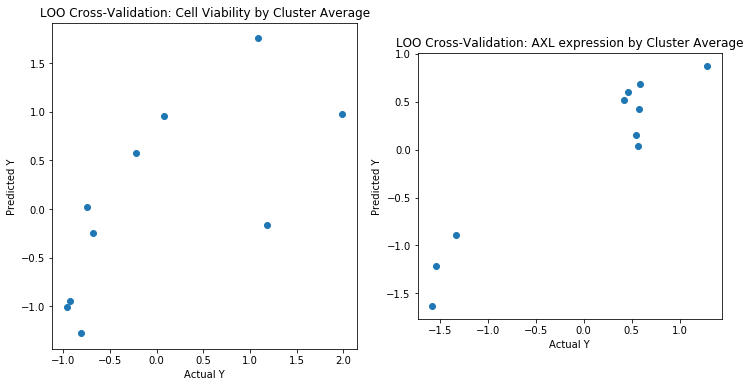

In [17]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
cross_validation_plot(X_ClusterAvgs_Fz,Y_axl_z,plsr_cvF,1,'LOO Cross-Validation: AXL expression by Cluster Average')
cross_validation_plot(X_ClusterAvgs_Fz,Y_cv_z,plsr_cvF,0,'LOO Cross-Validation: Cell Viability by Cluster Average')
axs[1].set_aspect('equal')
plt.show()

### Results: AXL Expression

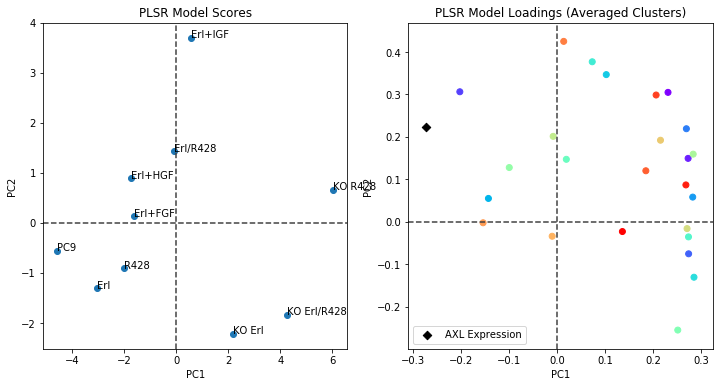

In [18]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, 25))
axs[0].scatter(PC1_scores_axlF,PC2_scores_axlF)
for j, txt in enumerate(treatments_axl):
    axs[0].annotate(txt, (PC1_scores_axlF[j], PC2_scores_axlF[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[1].scatter(PC1_xload_axlF, PC2_xload_axlF, c=np.arange(25), cmap=colors.ListedColormap(colors_))
cl = []
for i in range(25):
    i += 1
    Var = str(i)
    cl.append(Var)
cls = np.array(cl)
# for j, txt in enumerate(cls):      #number clusters in loadings plot
#     axs[1].annotate(txt, (PC1_xload_axlF[j], PC2_xload_axlF[j]))
axs[1].scatter(PC1_yload_axlF, PC2_yload_axlF, color='#000000', marker='D', label='AXL Expression')
axs[1].legend(loc=3)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
plt.show()

### Results: Cell Viability

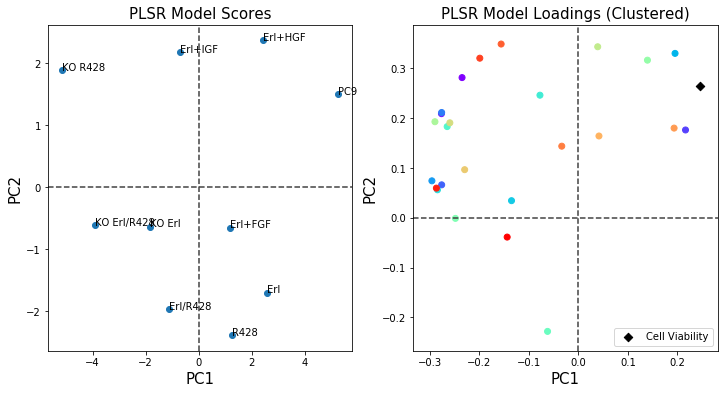

In [19]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, 25))
axs[0].scatter(PC1_scores_cvF,PC2_scores_cvF)
for j, txt in enumerate(treatments_axl):
    axs[0].annotate(txt, (PC1_scores_cvF[j], PC2_scores_cvF[j]))
axs[0].set_title('PLSR Model Scores', fontsize = 15)
axs[0].set_xlabel('PC1', fontsize = 15)
axs[0].set_ylabel('PC2', fontsize = 15)
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[1].scatter(PC1_xload_cvF, PC2_xload_cvF, c=np.arange(25), cmap=colors.ListedColormap(colors_))
cl = []
for i in range(25):
    i += 1
    Var = str(i)
    cl.append(Var)
cls = np.array(cl)
# for j, txt in enumerate(cls):         #number clusters in loadings plot
#     axs[1].annotate(txt, (PC1_xload_cvF[j], PC2_xload_cvF[j]))
axs[1].scatter(PC1_yload_cvF, PC2_yload_cvF, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Clustered)', fontsize = 15)
axs[1].set_xlabel('PC1', fontsize = 15)
axs[1].set_ylabel('PC2', fontsize = 15)
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
plt.show()